In [12]:
from pathlib import Path

pred_path = Path("basegemini2.jsonl")  # or .json but in your concatenated format
text = pred_path.read_text(encoding="utf-8")

print(text[:300])


[
  {
    "id": "st_step159529_1",
    "org:resource": "STAFF MEMBER",
    "concept:name": "Request For Payment APPROVED by PRE_APPROVER",
    "time:timestamp": "2018-02-21 10:00:00+00:00",
    "org:role": "PRE_APPROVER",
    "case:Rfp_id": "request for payment 159525",
    "case:Project": "project


In [13]:
import json

def extract_top_level_json_arrays(text: str):
    arrays = []
    i, n = 0, len(text)
    while i < n:
        # find next '['
        if text[i] != '[':
            i += 1
            continue

        start = i
        depth = 0
        in_str = False
        esc = False
        i += 1
        depth = 1

        while i < n and depth > 0:
            ch = text[i]

            if in_str:
                if esc:
                    esc = False
                elif ch == '\\':
                    esc = True
                elif ch == '"':
                    in_str = False
            else:
                if ch == '"':
                    in_str = True
                elif ch == '[':
                    depth += 1
                elif ch == ']':
                    depth -= 1

            i += 1

        arr_str = text[start:i].strip()
        if arr_str:
            arrays.append(json.loads(arr_str))

    return arrays

pred_traces = extract_top_level_json_arrays(text)
len(pred_traces), type(pred_traces[0]), type(pred_traces[0][0])


(50, list, dict)

In [14]:
pred_by_case = {}
dupes = 0

for trace in pred_traces:
    if not trace:
        continue
    case_id = trace[0].get("case:Rfp_id")
    if case_id is None:
        continue
    if case_id in pred_by_case:
        dupes += 1  # just to see if multiple predictions exist per same case
    pred_by_case[case_id] = trace

print("num cases:", len(pred_by_case), "duplicates overwritten:", dupes)

num cases: 50 duplicates overwritten: 0


In [15]:
import pandas as pd

# --- Cell 4: Build ground-truth sequences ONLY for the cases that have LLM predictions ---

# 1) Collect predicted case ids (strings like "request for payment 166609")
pred_case_ids = [cid for cid in pred_by_case.keys() if cid is not None]
pred_case_ids_set = {str(cid).strip() for cid in pred_case_ids}

print("Predicted cases (from LLM):", len(pred_case_ids_set))

# 2) Load real event log (CSV) and normalize case ids to avoid whitespace/casing issues
real_log = pd.read_csv("C:/Users/Deniz/Downloads/thesisData2.csv")

real_log["case:Rfp_id"] = real_log["case:Rfp_id"].astype(str).str.strip()
real_log["case:Rfp_id_norm"] = real_log["case:Rfp_id"].str.lower()

pred_case_ids_norm = {cid.lower() for cid in pred_case_ids_set}

# 3) Filter real log to only those predicted cases
real_log_50 = real_log[real_log["case:Rfp_id_norm"].isin(pred_case_ids_norm)].copy()
print("Real events after filtering:", real_log_50.shape)
print("Unique cases matched in real log:", real_log_50["case:Rfp_id"].nunique())

# 4) Parse timestamps and build ordered ground-truth activity sequences for those cases only
real_log_50["time:timestamp"] = pd.to_datetime(real_log_50["time:timestamp"], utc=True, errors="coerce")
real_log_50 = real_log_50.sort_values(["case:Rfp_id", "time:timestamp"])

gt_map = (
    real_log_50
    .groupby("case:Rfp_id")["concept:name"]
    .apply(list)
    .to_dict()
)

print("GT sequences built:", len(gt_map))

# 5) Sanity check: which predicted cases are missing in ground truth?
gt_case_ids_norm = {cid.lower() for cid in gt_map.keys()}
missing_in_gt = sorted(list(pred_case_ids_norm - gt_case_ids_norm))
print("Predicted cases missing in ground truth:", len(missing_in_gt))
if missing_in_gt:
    print("Example missing ids:", missing_in_gt[:5])

Predicted cases (from LLM): 50
Real events after filtering: (266, 16)
Unique cases matched in real log: 50
GT sequences built: 50
Predicted cases missing in ground truth: 0


In [16]:
import numpy as np
import pandas as pd

def normalize_prediction_to_start_after_first(gt_seq, pred_seq):
    if not gt_seq:
        return pred_seq, "no_gt"
    if not pred_seq:
        return pred_seq, "empty_pred"

    gt0 = gt_seq[0]
    gt1 = gt_seq[1] if len(gt_seq) > 1 else None
    p0 = pred_seq[0]

    # prediction includes the given first step -> drop it
    if p0 == gt0:
        return pred_seq[1:], "dropped_prefix_gt0"

    # prediction already starts from second step -> keep it
    if gt1 is not None and p0 == gt1:
        return pred_seq, "already_next_step"

    # if gt0 appears later in prediction, trim up to it (inclusive)
    if gt0 in pred_seq:
        idx = pred_seq.index(gt0)
        return pred_seq[idx+1:], "trimmed_to_gt0_inside_pred"

    return pred_seq, "unaligned"


normalized_preds = {}
status_rows = []

for case_id, trace in pred_by_case.items():
    # predicted activity sequence from LLM trace
    pred_seq = [e.get("concept:name") for e in trace if "concept:name" in e]

    # ground truth activity sequence
    gt_seq = gt_map.get(case_id, [])

    norm_seq, status = normalize_prediction_to_start_after_first(gt_seq, pred_seq)

    normalized_preds[case_id] = norm_seq
    status_rows.append({
        "case:Rfp_id": case_id,
        "status": status,
        "pred_len_raw": len(pred_seq),
        "pred_len_norm": len(norm_seq),
        "gt_len": len(gt_seq),
        "gt_first": gt_seq[0] if gt_seq else None,
        "pred_first": pred_seq[0] if pred_seq else None
    })

status_df = pd.DataFrame(status_rows)

status_df["status"].value_counts()
status_df.sort_values("status").head(10)


,case:Rfp_id,status,pred_len_raw,pred_len_norm,gt_len,gt_first,pred_first
24,request for payment 148607,already_next_step,4,4,5,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER
23,request for payment 150787,already_next_step,3,3,5,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER
6,request for payment 148339,already_next_step,4,4,5,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER
15,request for payment 149581,already_next_step,4,4,4,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER
37,request for payment 150537,already_next_step,4,4,5,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER
2,request for payment 153630,dropped_prefix_gt0,5,4,6,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment SUBMITTED by EMPLOYEE
29,request for payment 166944,unaligned,4,4,5,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER
30,request for payment 169366,unaligned,5,5,6,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER
31,request for payment 172098,unaligned,4,4,3,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER
32,request for payment 173894,unaligned,4,4,8,Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER


In [17]:
import pandas as pd
import numpy as np

# ---- 0) Known activity set (from REAL data) ----
known_activities = set(real_log_50["concept:name"].dropna().astype(str).unique())

# ---- 1) REAL case-level aggregates ----
real_case = (
    real_log_50
    .groupby("case:Rfp_id")
    .agg(
        requested_amount=("case:RequestedAmount", "first"),
        organizational_entity=("case:OrganizationalEntity", "first"),
        project=("case:Project", "first"),
        real_first_ts=("time:timestamp", "min"),
        real_last_ts=("time:timestamp", "max"),
        real_step_count=("concept:name", "count"),
    )
    .reset_index()
)

real_case["real_time_taken"] = real_case["real_last_ts"] - real_case["real_first_ts"]

# Since we start from step 2: continuation length = total steps - 1
real_case["real_step_count_cont"] = (real_case["real_step_count"] - 1).clip(lower=0)

# Messy definition for continuation (steps > 4)
real_case["real_messy"] = (real_case["real_step_count_cont"] > 4).astype(int)


# ---- 2) PREDICTED case-level aggregates (using normalized continuation) ----
pred_rows = []

for case_id, trace in pred_by_case.items():
    # normalized continuation activities (already starts after step 1)
    pred_cont_acts = normalized_preds.get(case_id, [])
    pred_step_count_cont = len(pred_cont_acts)

    # activity-known: fraction of predicted continuation activities that are in known real activity set
    if pred_step_count_cont > 0:
        known_flags = [str(a) in known_activities for a in pred_cont_acts]
        is_activity_known = float(np.mean(known_flags))
    else:
        is_activity_known = 0.0

    # predicted last timestamp: take last timestamp from the PREDICTED TRACE after normalization
    # We need timestamps, so we normalize the trace events similarly (drop/trim) based on gt prefix if needed.
    # We'll reuse the same alignment logic on the EVENT objects, not only on names.

    gt_seq = gt_map.get(case_id, [])
    pred_seq = [e.get("concept:name") for e in trace if "concept:name" in e]
    pred_ts = [e.get("time:timestamp") for e in trace if "time:timestamp" in e]

    # Build list of (name, ts) pairs
    pairs = [(e.get("concept:name"), e.get("time:timestamp")) for e in trace if "concept:name" in e]

    # Normalize pairs the same way as activities
    def normalize_pairs_to_start_after_first(gt_seq, pairs):
        if not gt_seq:
            return pairs, "no_gt"
        if not pairs:
            return pairs, "empty_pred"
        gt0 = gt_seq[0]
        gt1 = gt_seq[1] if len(gt_seq) > 1 else None
        p0 = pairs[0][0]

        if p0 == gt0:
            return pairs[1:], "dropped_prefix_gt0"
        if gt1 is not None and p0 == gt1:
            return pairs, "already_next_step"
        names = [p[0] for p in pairs]
        if gt0 in names:
            idx = names.index(gt0)
            return pairs[idx+1:], "trimmed_to_gt0_inside_pred"
        return pairs, "unaligned"

    norm_pairs, _ = normalize_pairs_to_start_after_first(gt_seq, pairs)

    # Parse timestamps and get predicted last ts from normalized continuation
    norm_ts = [pd.to_datetime(ts, utc=True, errors="coerce") for (_, ts) in norm_pairs]
    pred_last_ts = max([t for t in norm_ts if pd.notna(t)], default=pd.NaT)

    pred_rows.append({
        "case:Rfp_id": case_id,
        "is_activity_known": is_activity_known,
        "pred_step_count_cont": pred_step_count_cont,
        "pred_messy": int(pred_step_count_cont > 4),
        "pred_last_ts": pred_last_ts
    })

pred_case = pd.DataFrame(pred_rows)

# ---- 3) Merge & compute predicted time taken relative to REAL first timestamp ----
df_case = real_case.merge(pred_case, on="case:Rfp_id", how="inner")

df_case["predicted_time_taken"] = df_case["pred_last_ts"] - df_case["real_first_ts"]

# Optional: keep a clean final column order
df_case = df_case[[
    "case:Rfp_id",
    "requested_amount",
    "organizational_entity",
    "project",
    "is_activity_known",
    "real_messy",
    "pred_messy",
    "real_time_taken",
    "predicted_time_taken",
    "real_step_count",
    "real_step_count_cont",
    "pred_step_count_cont",
    "real_first_ts",
    "real_last_ts",
    "pred_last_ts"
]]

df_case.head()


,case:Rfp_id,requested_amount,organizational_entity,project,is_activity_known,real_messy,pred_messy,real_time_taken,predicted_time_taken,real_step_count,real_step_count_cont,pred_step_count_cont,real_first_ts,real_last_ts,pred_last_ts
0,request for payment 148298,295.282812,organizational unit 65458,project 147546,1.0,0,0,2 days 08:25:13,0 days 04:00:00,4,3,4,2017-03-28 09:06:04+00:00,2017-03-30 17:31:17+00:00,2017-03-28 13:06:04+00:00
1,request for payment 148339,23.665911,organizational unit 65463,project 147531,1.0,0,0,9 days 00:02:04,4 days 00:00:00,5,4,4,2017-06-06 17:29:08+00:00,2017-06-15 17:31:12+00:00,2017-06-10 17:29:08+00:00
2,request for payment 148598,2573.610190,organizational unit 65458,project 503,1.0,0,0,10 days 20:44:06,0 days 00:00:00,5,4,4,2017-02-23 20:47:04+00:00,2017-03-06 17:31:10+00:00,2017-02-23 20:47:04+00:00
3,request for payment 148607,20.297627,organizational unit 65463,project 147556,1.0,0,0,6 days 01:47:13,0 days 00:00:04,5,4,4,2017-03-03 15:44:09+00:00,2017-03-09 17:31:22+00:00,2017-03-03 15:44:13+00:00
4,request for payment 148757,28.070988,organizational unit 65463,project 503,1.0,1,0,13 days 03:44:21,4 days 00:00:00,7,6,4,2017-01-26 11:55:32+00:00,2017-02-08 15:39:53+00:00,2017-01-30 11:55:32+00:00


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# y_true: real workflow messiness
y_true = df_case["real_messy"]

# y_pred: LLM-predicted workflow messiness
y_pred = df_case["pred_messy"]

# Compute metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"Accuracy : {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall   : {recall:.3f}")
print(f"F1-score : {f1:.3f}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(
    cm,
    index=["Real: Not Messy", "Real: Messy"],
    columns=["Pred: Not Messy", "Pred: Messy"]
)

cm_df

Accuracy : 0.660
Precision: 0.500
Recall   : 0.059
F1-score : 0.105


,Pred: Not Messy,Pred: Messy
Real: Not Messy,32,1
Real: Messy,16,1


Design matrix shape: (50, 32)
Class balance (pred_messy):
pred_messy
0    48
1     2
Name: count, dtype: int64


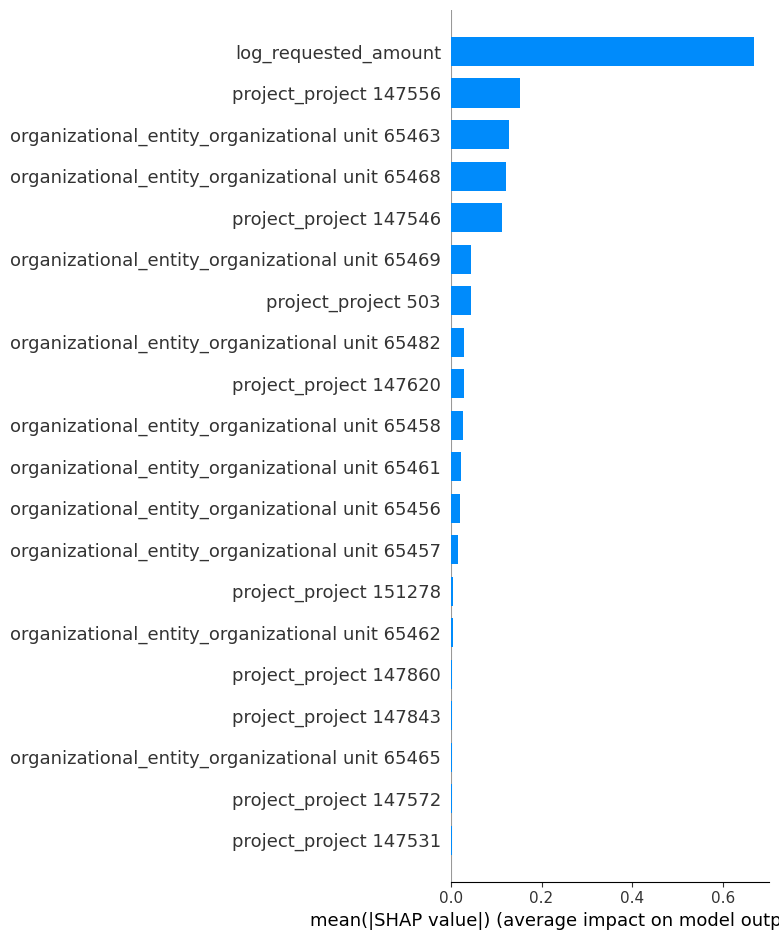

,feature,coef,odds_ratio
0,project_project 147620,0.773795,2.167979
1,organizational_entity_organizational unit 65482,0.773795,2.167979
2,organizational_entity_organizational unit 65468,0.674760,1.963561
3,project_project 147546,0.327231,1.387122
4,project_project 149268,-0.007660,0.992370
5,project_project 155217,-0.007817,0.992214
6,project_project 152803,-0.011401,0.988663
7,project_project 150197,-0.011691,0.988377
8,project_project 147649,-0.023795,0.976486
9,project_project 154479,-0.031802,0.968698


In [19]:
# =========================
# PART B — Explanatory model
# y = LLM-predicted messiness (pred_messy)
# X = requested_amount, project, organizational_entity, is_activity_known
# + SHAP explanations
# + 5-fold CV for coefficient stability (no performance metrics)
# =========================

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

import shap


# ---------- B0) Select features and target ----------
X = df_case[
    ["requested_amount", "project", "organizational_entity", "is_activity_known"]
].copy()

y = df_case["pred_messy"].astype(int).copy()

# Optional safety: drop missing rows (should be none ideally)
mask = X.notna().all(axis=1) & y.notna()
X, y = X.loc[mask].reset_index(drop=True), y.loc[mask].reset_index(drop=True)


# ---------- B1) Preprocess ----------
# log-transform amount (recommended for skewed amounts)
X["log_requested_amount"] = np.log1p(X["requested_amount"])
X = X.drop(columns=["requested_amount"])

# one-hot encode categorical fixed effects
X = pd.get_dummies(
    X,
    columns=["project", "organizational_entity"],
    drop_first=True
)

print("Design matrix shape:", X.shape)
print("Class balance (pred_messy):")
print(y.value_counts(dropna=False))


# ---------- B2) Fit final model on full data (for final coefficients + SHAP) ----------
final_model = LogisticRegression(max_iter=2000, solver="liblinear")
final_model.fit(X, y)




# ---------- B3) SHAP explanations (global) ----------
explainer = shap.LinearExplainer(final_model, X)
shap_values = explainer.shap_values(X)

# Global importance (bar)
shap.summary_plot(shap_values, X, plot_type="bar")

# Detailed effects (beeswarm)
#shap.summary_plot(shap_values, X)


pd.set_option("display.max_rows", 200)   # adjust if needed
pd.set_option("display.max_columns", 50)

coef_overview = (
    pd.DataFrame({
        "feature": X.columns,
        "coef": final_model.coef_[0],
        "odds_ratio": np.exp(final_model.coef_[0]),
    })
    .sort_values("coef", ascending=False)
    .reset_index(drop=True)
)

coef_overview


explainer = shap.LinearExplainer(final_model, X)
shap_values = explainer.shap_values(X)

shap_matrix = pd.DataFrame(shap_values, columns=X.columns)




coef_df = (
    pd.DataFrame({
        "feature": X.columns,
        "coef": final_model.coef_[0],
        "odds_ratio": np.exp(final_model.coef_[0]),
    })
    .sort_values("coef", ascending=False)
    .reset_index(drop=True)
)

coef_df




In [20]:
shap_overview = (
    pd.DataFrame({
        "feature": X.columns,
        "mean_abs_shap": shap_matrix.abs().mean().values,
        "mean_shap": shap_matrix.mean().values,
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

shap_overview

,feature,mean_abs_shap,mean_shap
0,log_requested_amount,0.66824,-0.0
1,project_project 147556,0.152361,0.0
2,organizational_entity_organizational unit 65463,0.128437,0.0
3,organizational_entity_organizational unit 65468,0.121457,0.0
4,project_project 147546,0.112306,0.0
5,organizational_entity_organizational unit 65469,0.045434,-0.0
6,project_project 503,0.044576,-0.0
7,organizational_entity_organizational unit 65482,0.030333,0.0
8,project_project 147620,0.030333,0.0
9,organizational_entity_organizational unit 65458,0.026726,0.0
